<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

In [29]:
np.linspace?

In [4]:
X

array([-2.        , -1.33333333, -0.66666667,  0.        ,  0.66666667,
        1.33333333,  2.        ])

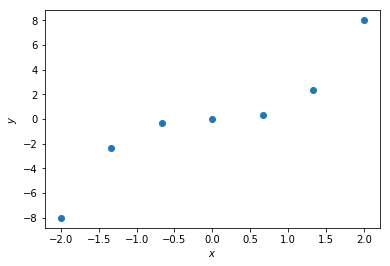

In [3]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

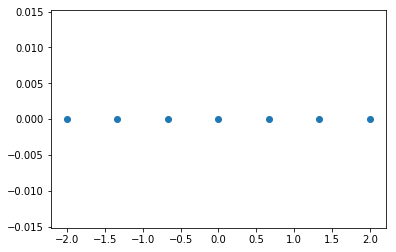

In [5]:
# Ваш код здесь
y_pred = np.mean(y) * np.ones(7)
_ = plt.scatter(X, y_pred)

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [42]:
np.concatenate?

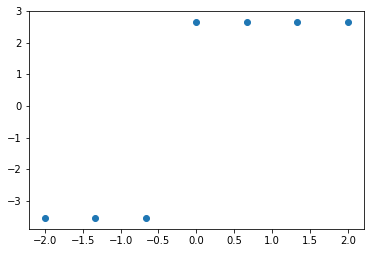

In [6]:
# Ваш код здесь
X_mask = X < 0
y_left = np.mean(y[X_mask]) * np.ones(sum(X_mask))
y_right = np.mean(y[~X_mask]) * np.ones(sum(~X_mask))
_ = plt.scatter(X, np.concatenate((y_left, y_right)))

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}\left(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i\right)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [111]:
np.std?

In [12]:
from __future__ import print_function

In [32]:
def dispersion(sample):
    sample_mean = np.mean(sample)
    return sum([(z - sample_mean) ** 2 for z in sample]) / float(len(sample))
    # return np.std(sample) ** 2

def regression_var_criterion(X, y, t):
    X_mask = X < t
    y_left, y_right = y[X_mask], y[~X_mask]
    return dispersion(y) - (len(y_left) * dispersion(y_left) + len(y_right) * dispersion(y_right)) / float(len(y))

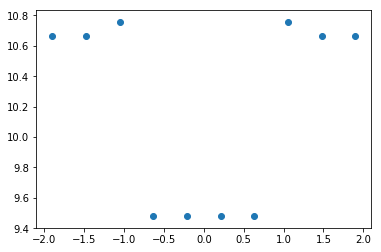

In [33]:
# Ваш код здесь
xs = np.linspace(-1.9, 1.9, 10)
ys = [regression_var_criterion(X, y, t) for t in xs]
_ = plt.scatter(xs, ys)

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

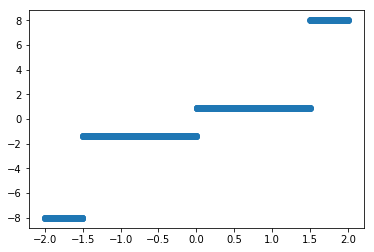

In [41]:
X1 = X < -1.5
X2 = (-1.5 <= X) & (X < 0)
X3 = (0 <= X) & (X < 1.5)
X4 = 1.5 <= X
y1 = np.mean(y[X1]) * np.ones(sum(X1))
y2 = np.mean(y[X2]) * np.ones(sum(X2))
y3 = np.mean(y[X3]) * np.ones(sum(X3))
y4 = np.mean(y[X4]) * np.ones(sum(X4))

def ad_hoc_tree(t):
    if t < 0:
        if t < -1.5:
            return np.mean(y[X1])
        else:
            return np.mean(y[X2])
    else:
        if t < 1.5:
            return np.mean(y[X3])
        else:
            return np.mean(y[X4])

xs = np.linspace(-2, 2, 1000)
ys = [ad_hoc_tree(x) for x in xs]

# _ = plt.scatter(X, np.concatenate((y1, y2, y3, y4)))
_ = plt.scatter(xs, ys)

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [2]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [167]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [3]:
# Ваш код здесь
test = df['age'] / 365
test = test.astype(int)
test1 = df['age'] / 365.25
test1 = test1.astype(int)
mismatch = sum([1 for x1, x2 in zip(test, test1) if x1 != x2])
print mismatch

2619


In [4]:
YEAR_DURATION = 365

In [5]:
df['year_age'] = (df['age'] / YEAR_DURATION).astype(int)

In [6]:
df = pd.concat([df, pd.get_dummies(df['cholesterol'], prefix='cholesterol'), pd.get_dummies(df['gluc'], prefix='gluc')], axis=1)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,year_age,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,1,0,0,1,0,0


In [7]:
df.drop(['cholesterol', 'gluc', 'age'], axis=1, inplace=True)
df.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,year_age,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,0,50,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,1,55,0,0,1,1,0,0
2,1,165,64.0,130,70,0,0,0,1,51,0,0,1,1,0,0
3,2,169,82.0,150,100,0,0,1,1,48,1,0,0,1,0,0
4,1,156,56.0,100,60,0,0,0,0,47,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [8]:
y = df['cardio']
X = df.drop(['cardio'], axis=1)

In [9]:
y.shape, X.shape

((70000,), (70000, 15))

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17) # Ваш код здесь

In [11]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((49000, 15), (49000,), (21000, 15), (21000,))

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [12]:
# Ваш код здесь
tree_with_maxdepth_3 = DecisionTreeClassifier(max_depth=3, random_state=17)

In [13]:
%%time
tree_with_maxdepth_3.fit(X_train, y_train)

Wall time: 109 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [14]:
export_graphviz(tree_with_maxdepth_3, out_file='cardio_tree.dot', feature_names=X.columns, filled=True)

In [15]:
!dot -Tpng cardio_tree.dot -o cardio_tree.png

<img src="cardio_tree.png">

In [16]:
# year_age, ap_hi, cholesterol_3

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [17]:
# Ваш код здесь
y_pred = tree_with_maxdepth_3.predict(X_valid)

In [18]:
acc_1 = accuracy_score(y_valid, y_pred)
acc_1

0.7212857142857143

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [19]:
tree_params = {'max_depth': range(2, 11)}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5, n_jobs=-1) # Ваш код здесь

In [20]:
%%time
tree_grid.fit(X_train, y_train)

Wall time: 8.94 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [21]:
tree_grid.grid_scores_[1][1]

C:\Python27\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.7277142857142858

In [22]:
# Ваш код здесь
def plot_values(results, parameter='max_depth'):
    _ = plt.plot([row[0][parameter] for row in results], [row[1] for row in results])

C:\Python27\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


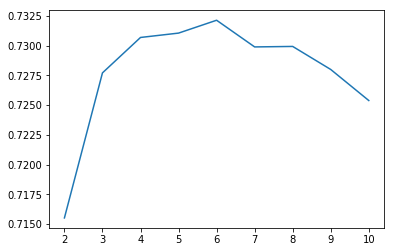

In [23]:
plot_values(tree_grid.grid_scores_)

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [24]:
# Ваш код здесь
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 6}, 0.7321428571428571)

In [25]:
# acc_2 = tree_grid.best_score_
y_pred2 = tree_grid.predict(X_valid)
acc_2 = accuracy_score(y_valid, y_pred2)

In [26]:
acc_2

0.7258571428571429

In [28]:
result = (acc_2 - acc_1) / acc_1 * 100
result

0.633788869082985

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [42]:
# Ваш код здесь
df_1 = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [43]:
df_1['age'] = (df_1['age'] / 365).astype(int)

In [44]:
df_1['age_45'] = (df_1['age'] >= 45) & (df_1['age'] < 50)
df_1.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_45
id,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0,False
1,55,1,156,85.0,140,90,3,1,0,0,1,1,False
2,51,1,165,64.0,130,70,3,1,0,0,0,1,False
3,48,2,169,82.0,150,100,1,1,0,0,1,1,True
4,47,1,156,56.0,100,60,1,1,0,0,0,0,True


In [45]:
df_1['age_45'] = df_1['age_45'].astype(int)

In [46]:
df_1.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_45
id,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1,0
2,51,1,165,64.0,130,70,3,1,0,0,0,1,0
3,48,2,169,82.0,150,100,1,1,0,0,1,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0,1


In [47]:
df_1['age_50'] = ((df_1['age'] >= 50) & (df_1['age'] < 55)).astype(int)
df_1['age_55'] = ((df_1['age'] >= 55) & (df_1['age'] < 60)).astype(int)
df_1['age_60'] = ((df_1['age'] >= 60) & (df_1['age'] < 65)).astype(int)
df_1.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_45,age_50,age_55,age_60
id,,,,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0,0,1,0,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1,0,0,1,0
2,51,1,165,64.0,130,70,3,1,0,0,0,1,0,1,0,0
3,48,2,169,82.0,150,100,1,1,0,0,1,1,1,0,0,0
4,47,1,156,56.0,100,60,1,1,0,0,0,0,1,0,0,0


In [48]:
df_1['ap_hi_120_140'] = (df_1['ap_hi'] >= 120) & (df_1['ap_hi'] < 140)
df_1['ap_hi_140_160'] = (df_1['ap_hi'] >= 140) & (df_1['ap_hi'] < 160)
df_1['ap_hi_160_180'] = (df_1['ap_hi'] >= 160) & (df_1['ap_hi'] < 180)

In [69]:
df_1['ap_hi_120_140'] = df_1['ap_hi_120_140'].astype(int)
df_1['ap_hi_140_160'] = df_1['ap_hi_140_160'].astype(int)
df_1['ap_hi_160_180'] = df_1['ap_hi_160_180'].astype(int)
df_1.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_45,age_50,age_55,age_60,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180
id,,,,,,,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0,0,1,0,0,0,0,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1,0,0,1,0,0,1,0
2,51,1,165,64.0,130,70,3,1,0,0,0,1,0,1,0,0,1,0,0
3,48,2,169,82.0,150,100,1,1,0,0,1,1,1,0,0,0,0,1,0
4,47,1,156,56.0,100,60,1,1,0,0,0,0,1,0,0,0,0,0,0


In [49]:
df_1.drop(['age', 'ap_hi'], axis=1, inplace=True)

In [50]:
df_1.drop(['height', 'weight', 'ap_lo', 'active', 'gluc', 'alco'], axis=1, inplace=True)

In [51]:
df_1['male'] = df_1['gender'].map({ 1 : 0, 2 : 1 })

In [52]:
df_1.drop(['gender'], axis=1, inplace=True)

In [53]:
df_1 = pd.concat([df_1, pd.get_dummies(df_1['cholesterol'], prefix='cholesterol')], axis=1)

In [54]:
df_1.drop(['cholesterol'], axis=1, inplace=True)

In [55]:
y = df_1['cardio']

In [56]:
X = df_1.drop(['cardio'], axis=1)

In [57]:
X.head()

,smoke,age_45,age_50,age_55,age_60,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,male,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,
0,0,0,1,0,0,False,False,False,1,1,0,0
1,0,0,0,1,0,False,True,False,0,0,0,1
2,0,0,1,0,0,True,False,False,0,0,0,1
3,0,1,0,0,0,False,True,False,1,1,0,0
4,0,1,0,0,0,False,False,False,0,1,0,0


In [64]:
cardio_tree = DecisionTreeClassifier(max_depth=3, random_state=3)
cardio_tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [65]:
export_graphviz(cardio_tree, out_file='cardio_tree_1.dot', feature_names=X.columns, filled=True)

In [66]:
!dot -Tpng cardio_tree_1.dot -o cardio_tree_1.png

<img src='cardio_tree_1.png'>